source https://www.tensorflow.org/addons/tutorials/losses_triplet

In [1]:
import io
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Prepare the data

In [3]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

2021-11-06 17:34:02.475082: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2021-11-06 17:34:13.812912: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-11-06 17:34:13.812945: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-06 17:34:13.812962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist


# Build the model

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# Train and Evaluate

In [15]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [16]:
# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

Epoch 1/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.8421
Epoch 2/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7907
Epoch 3/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7750
Epoch 4/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.7627
Epoch 5/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.7614


In [17]:
# Evaluate the network
results = model.predict(test_dataset)

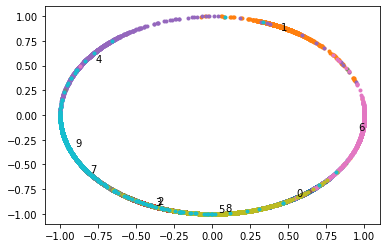

In [24]:
import matplotlib.pyplot as plt

labels = np.concatenate([label for img, label in test_dataset], axis=0)
fig, ax = plt.subplots()
for i in np.unique(labels):
    select = labels==i
    ax.plot(results[select, 0], results[select, 1], linestyle="", marker=".")
    ax.text(np.mean(results[select, 0]), np.mean(results[select, 1]), s=i)
plt.show()

In [13]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


try:
    from google.colab import files
    files.download('vecs.tsv')
    files.download('meta.tsv')
except:
    pass